# Sentiment Analysis with Regular Classifier

## Step 1: Explore the data

The dataset used is the [IMDb dataset](http://ai.stanford.edu/~amaas/data/sentiment/). It consists of movie reviews from the website [imdb.com](http://www.imdb.com/), each labeled as either '**pos**itive', if the reviewer enjoyed the film, or '**neg**ative' otherwise.

> Maas, Andrew L., et al. [Learning Word Vectors for Sentiment Analysis](http://ai.stanford.edu/~amaas/data/sentiment/). In _Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies_. Association for Computational Linguistics, 2011.

In [13]:
import os
import glob

def read_imdb_data(data_dir='imdb-reviews'):
    # Data, labels to be returned in nested dicts.
    data = {}
    labels = {}

    # Assume 2 sub-directories: train, test
    for data_type in ['train', 'test']:
        data[data_type] = {}
        labels[data_type] = {}

        # Assume 2 sub-directories for sentiment (label): pos, neg.
        for sentiment in ['pos', 'neg']:
            data[data_type][sentiment] = []
            labels[data_type][sentiment] = []
            
            # Fetch list of files for this sentiment.
            path = os.path.join(data_dir, data_type, sentiment, '*.txt')
            files = glob.glob(path)
            
            # Read reviews data and assign labels.
            for f in files:
                with open(f) as review:
                    data[data_type][sentiment].append(review.read())
                    labels[data_type][sentiment].append(sentiment)
            
            assert len(data[data_type][sentiment]) == len(labels[data_type][sentiment]), \
                    "{}/{} data size does not match labels size".format(data_type, sentiment)
    
    # Return data, labels as nested dicts.
    return data, labels

data, labels = read_imdb_data()
print("IMDb reviews: train = {} pos / {} neg, test = {} pos / {} neg".format(
        len(data['train']['pos']), len(data['train']['neg']),
        len(data['test']['pos']), len(data['test']['neg'])))

IMDb reviews: train = 12500 pos / 12500 neg, test = 12500 pos / 12500 neg


In [5]:
# Install wordcloud.
!pip install wordcloud

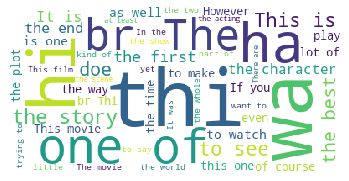

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS

sentiment = 'pos'

# Combine all reviews for the desired sentiment.
combined_text = " ".join([review for review in data['train'][sentiment]])

# Initialize wordcloud object.
wc = WordCloud(background_color='white', max_words=50,
        # Update stopwords to include common words like film and movie.
        stopwords = STOPWORDS.update(['br','film','movie']))

# Generate and plot wordcloud.
plt.imshow(wc.generate(combined_text))
plt.axis('off')
plt.show()

Try changing the sentiment to `'neg'` and see if you can spot any obvious differences between the wordclouds.

### Form training and test sets

In [14]:
from sklearn.utils import shuffle

def prepare_imdb_data(data):
    """Prepare training and test sets from IMDb movie reviews."""
    
    # Combine positive and negative reviews and labels.
    data_train = data['train']['pos'] + data['train']['neg']
    data_test = data['test']['pos'] + data['test']['neg']
    labels_train = labels['train']['pos'] + labels['train']['neg']
    labels_test = labels['test']['pos'] + labels['test']['neg']
    
    # Shuffle reviews and corresponding labels within training and test sets.
    data_train, labels_train = shuffle(data_train, labels_train)
    data_test, labels_test = shuffle(data_test, labels_test)
    
    # Return a unified training data, test data, training labels, test labels.
    return data_train, data_test, labels_train, labels_test

data_train, data_test, labels_train, labels_test = prepare_imdb_data(data)
print("IMDb reviews (combined): train = {}, test = {}".format(len(data_train), len(data_test)))

IMDb reviews (combined): train = 25000, test = 25000


## Step 2. Preprocessing

### Convert each review to words

In [15]:
from bs4 import BeautifulSoup 
import re
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

from nltk.stem.porter import *
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ellachang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
def review_to_words(review):
    """Convert a raw review string into a sequence of words."""
    
    # Remove HTML tags and non-letters.
    text = BeautifulSoup(review, 'html5lib').get_text()
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    
    # Convert to lowercase and tokenize.
    text = text.lower()
    words = text.split()
    
    # Remove stopwords and stem.
    words = [w for w in words if w not in stopwords.words('english')]
    words = [PorterStemmer().stem(w) for w in words]
    
    # Return final list of words.
    return words


review_to_words("""This is just a <em>test</em>.<br/><br />
But if it wasn't a test, it would make for a <b>Great</b> movie review!""")

['test', 'test', 'would', 'make', 'great', 'movi', 'review']

In [20]:
import pickle

cache_dir = os.path.join("cache", "sentiment_analysis")
os.makedirs(cache_dir, exist_ok=True)

def preprocess_data(data_train, data_test, labels_train, labels_test,
                    cache_dir=cache_dir, cache_file="preprocessed_data.pkl"):
    """Convert each review to words; read from cache if available."""

    # If cache_file is not None, try to read from it first.
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass
    
    # If cache is missing, create and write to a new one.
    if cache_data is None:
        # Preprocess training and test data to obtain words for each review.
        words_train = list(map(review_to_words, data_train))
        words_test = list(map(review_to_words, data_test))
        
        # Write to cache file for future runs.
        if cache_file is not None:
            cache_data = dict(words_train=words_train, words_test=words_test,
                              labels_train=labels_train, labels_test=labels_test)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file.
        words_train, words_test, labels_train, labels_test = (cache_data['words_train'],
                cache_data['words_test'], cache_data['labels_train'], cache_data['labels_test'])
    
    return words_train, words_test, labels_train, labels_test

# Preprocess data.
words_train, words_test, labels_train, labels_test = preprocess_data(
        data_train, data_test, labels_train, labels_test)

Read preprocessed data from cache file: preprocessed_data.pkl


## Step 3: Extracting Bag-of-Words features

### Compute Bag-of-Words features

Implement the `extract_BoW_features()` function, apply it to both training and test datasets, and store the results in `features_train` and `features_test` NumPy arrays, respectively. Choose a reasonable vocabulary size, say $|V| = 5000$, and keep only the top $|V|$ occuring words and discard the rest. This number will also serve as the number of columns in the BoW matrices.

> **Hint**: You may find it useful to take advantage of `CountVectorizer` from scikit-learn. Also make sure to pickle your Bag-of-Words transformation so that you can use it in future.

In [21]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.externals import joblib

def extract_BoW_features(words_train, words_test, vocabulary_size=5000,
                         cache_dir=cache_dir, cache_file="bow_features.pkl"):
    """Extract Bag-of-Words for a given set of documents, already preprocessed into words."""
    
    # If cache_file is not None, try to read from it first.
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = joblib.load(f)
            print("Read features from cache file:", cache_file)
        except:
            pass
    
    # If cache is missing, preprocess data and write to a new cache.
    if cache_data is None:
        # Create a vectorizer and fit it to documents.
        vectorizer = CountVectorizer(max_features=vocabulary_size,
                                    preprocessor=lambda x: x,
                                    tokenizer=lambda x: x)
        features_train = vectorizer.fit_transform(words_train).toarray()
        features_test = vectorizer.fit_transform(words_test).toarray()
        
        # Write to cache file for future runs (store vocabulary as well)
        if cache_file is not None:
            vocabulary = vectorizer.vocabulary_
            cache_data = dict(features_train=features_train, features_test=features_test,
                             vocabulary=vocabulary)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                joblib.dump(cache_data, f)
            print("Wrote features to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        features_train, features_test, vocabulary = (cache_data['features_train'],
                cache_data['features_test'], cache_data['vocabulary'])
    
    # Return both the extracted features as well as the vocabulary
    return features_train, features_test, vocabulary

# Extract Bag of Words features for both training and test datasets.
features_train, features_test, vocabulary = extract_BoW_features(words_train, words_test)

# Inspect the vocabulary that was computed.
print("Vocabulary: {} words".format(len(vocabulary)))

import random
print("Sample words: {}".format(random.sample(list(vocabulary.keys()), 8)))

# Sample.
print("\n--- Preprocessed words ---")
print(words_train[5])
print("\n--- Bag-of-Words features ---")
print(features_train[5])
print("\n--- Label ---")
print(labels_train[5])

/Users/ellachang/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Wrote features to cache file: bow_features.pkl
Vocabulary: 5000 words
Sample words: ['defin', 'broken', 'et', 'leader', 'amongst', 'jar', 'cup', 'low']

--- Preprocessed words ---
['famili', 'look', 'old', 'roadsid', 'attract', 'includ', 'father', 'coffe', 'tabl', 'book', 'come', 'across', 'ancient', 'decrepit', 'old', 'freak', 'show', 'run', 'eccentr', 'one', 'eye', 'man', 'famili', 'van', 'break', 'upon', 'leav', 'sideshow', 'forc', 'stay', 'nearli', 'abandon', 'fish', 'camp', 'site', 'prison', 'break', 'decad', 'prior', 'mani', 'film', 'freak', 'subgenr', 'horror', 'rang', 'tod', 'brown', 'belov', 'freak', '1932', 'alex', 'winter', 'hilari', 'freak', '1993', 'classic', 'soon', 'freak', 'side', 'sho', 'howev', 'never', 'ever', 'reach', 'classic', 'statu', 'well', 'obviou', 'clue', 'sad', 'state', 'genr', 'ridicul', 'bad', 'open', 'song', '17', 'year', 'old', 'daughter', 'obvious', 'older', 'natur', 'mother', 'film', 'much', 'go', 'write', 'subpar', 'complet', 'aw', 'bore', 'direct', 

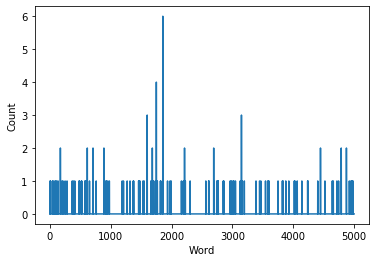

In [22]:
# Plot the BoW feature vector for a training document
plt.plot(features_train[5,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

### Zipf's law

[Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law), named after the famous American linguist George Zipf, is an empirical law stating that given a large collection of documents, the frequency of any word is inversely proportional to its rank in the frequency table. So the most frequent word will occur about twice as often as the second most frequent word, three times as often as the third most frequent word, and so on. In the figure below we plot number of appearances of each word in our training set against its rank.

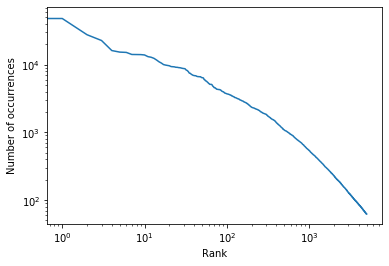

In [23]:
# Find number of occurrences for each word in the training set
word_freq = features_train.sum(axis=0)

# Sort it in descending order
sorted_word_freq = np.sort(word_freq)[::-1]

# Plot 
plt.plot(sorted_word_freq)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlabel('Rank')
plt.ylabel('Number of occurrences')
plt.show()

### TODO: Normalize feature vectors

Normalize the BoW feature vectors to have unit length. This makes sure that each document's representation retains the unique mixture of feature components, but prevents documents with large word counts from dominating those with fewer words.

In [25]:
import sklearn.preprocessing as pr

# Normalize BoW features in training and test set.
features_train = pr.normalize(features_train, axis=1)
features_test = pr.normalize(features_test, axis=1)

## Step 4: Classification using BoW features

To get a baseline model, train a Naive Bayes classifier from scikit-learn (specifically, [`GaussianNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)), and evaluate its accuracy on the test set.

In [26]:
from sklearn.naive_bayes import GaussianNB

# Train a Guassian Naive Bayes classifier.
clf1 = GaussianNB()
clf1.fit(features_train, labels_train)

# Calculate the mean accuracy score on training and test sets.
print("[{}] Accuracy: train = {}, test = {}".format(
        clf1.__class__.__name__,
        clf1.score(features_train, labels_train),
        clf1.score(features_test, labels_test)))

[GaussianNB] Accuracy: train = 0.8198, test = 0.50036


### Gradient-Boosted Decision Tree classifier

In [27]:
from sklearn.ensemble import GradientBoostingClassifier

n_estimators = 32

def classify_gboost(X_train, X_test, y_train, y_test):        
    # Initialize classifier.
    clf = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=1.0, max_depth=1, random_state=0)
    # Classify the data using GradientBoostingClassifier.
    clf.fit(X_train, y_train)
    # Print final training & test accuracy.
    print("[{}] Accuracy: train = {}, test = {}".format(
            clf.__class__.__name__,
            clf.score(X_train, y_train),
            clf.score(X_test, y_test)))
    # Return best classifier model.
    return clf


clf2 = classify_gboost(features_train, features_test, labels_train, labels_test)

[GradientBoostingClassifier] Accuracy: train = 0.79472, test = 0.52144


### Adverserial testing

In [28]:
# Write a sample review and set its true sentiment.
my_review = "I expected it to be cliche, but it turned out it was not!"
true_sentiment = 'pos'  # sentiment must be 'pos' or 'neg'

# Apply the same preprocessing and vectorizing steps as you did for your training data.
my_words = review_to_words(my_review)
vectorizer = CountVectorizer(vocabulary=vocabulary,
                             preprocessor=lambda x: x, tokenizer=lambda x: x)
my_bow_features = vectorizer.fit_transform([my_words]).toarray()

# Call the classifier to label it
predicted_sentiment = clf2.predict(my_bow_features)[0]
print("--- My review ---")
print(my_review)
print("\n--- Preprocessed words ---")
print(my_words)
print("\nTrue sentiment: {}, predicted sentiment: {}".format(true_sentiment, predicted_sentiment))

--- My review ---
I expected it to be cliche, but it turned out it was not!

--- Preprocessed words ---
['expect', 'clich', 'turn']

True sentiment: pos, predicted sentiment: pos
